In [133]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Bingo\Documents\Ibas\ahmad sahroni-5k-tweets - ahmad sahroni-5k-tweets.csv', index_col=0, encoding = 'unicode_escape')
#Text-en is fine

df_copy = df
print(len(df_copy))
serlis=df_copy.duplicated().tolist()
print(serlis.count(True)) #7479

serlis=df_copy.duplicated(['Text_en']).tolist()
print(serlis.count(True))

5000
33
1196


In [134]:
df.head()

,Datetime,Text,Text_en
0,2020-04-04 10:05:15+00:00,inspirasi sore - kisah bang ahmad sahroni http...,inspiring afternoon - bang story ahmad Sahroni...
1,2020-04-04 08:59:42+00:00,@sobatBSI @BumiSuksesindo,@sobatBSI @BumiSuksesindo
2,2020-04-04 08:59:07+00:00,Beberapa langkah drastis diambil oleh manajeme...,"Some drastic measures taken by management, suc..."
3,2020-04-03 04:27:11+00:00,Ahmad sahroni ngapain tu,Ahmad Sahroni doing tu
4,2020-04-03 02:36:51+00:00,"Sukses bisnis, mudah2an amanah di legislatif. ...","Business success, mudah2an in the legislative ..."


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  5000 non-null   object
 1   Text      5000 non-null   object
 2   Text_en   5000 non-null   object
dtypes: object(3)
memory usage: 156.2+ KB


In [136]:
import pandas as pd
import re
import time
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [137]:
df_copy=df_copy.drop_duplicates(['Text_en'])
df_copy=df_copy.reset_index(drop=True)

In [138]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3804 entries, 0 to 3803
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  3804 non-null   object
 1   Text      3804 non-null   object
 2   Text_en   3804 non-null   object
dtypes: object(3)
memory usage: 89.3+ KB


In [139]:
    # BASIC CLEANING FUNCTION
    for i in range(len(df_copy)):
        txt = df_copy.loc[i]["Text_en"]
        txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#username-tags
        txt=re.sub(r'^[RT]+','',txt)#RT-tags
        txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#URLs
        txt=re.sub("[^a-zA-Z]", " ",txt)#hashtags
        df_copy.at[i,"Text_en"]=txt

In [140]:
df_copy.head()

,Datetime,Text,Text_en
0,2020-04-04 10:05:15+00:00,inspirasi sore - kisah bang ahmad sahroni http...,inspiring afternoon bang story ahmad Sahroni...
1,2020-04-04 08:59:42+00:00,@sobatBSI @BumiSuksesindo,
2,2020-04-04 08:59:07+00:00,Beberapa langkah drastis diambil oleh manajeme...,Some drastic measures taken by management suc...
3,2020-04-03 04:27:11+00:00,Ahmad sahroni ngapain tu,Ahmad Sahroni doing tu
4,2020-04-03 02:36:51+00:00,"Sukses bisnis, mudah2an amanah di legislatif. ...",Business success mudah an in the legislative ...


In [141]:
pstem = PorterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [142]:
    #POS-TAGGING AND SENTIMENT SCORE
    li_swn=[]
    li_swn_pos=[]
    li_swn_neg=[]
    missing_words=[]
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['Text_en']
        tokens = nltk.word_tokenize(text)
        tagged_sent = pos_tag(tokens)
        store_it = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tagged_sent]
        #print("Tagged Parts of Speech:",store_it)

        pos_total=0
        neg_total=0
        for word,tag in store_it:
            if(tag=='NOUN'):
                tag='n'
            elif(tag=='VERB'):
                tag='v'
            elif(tag=='ADJ'):
                tag='a'
            elif(tag=='ADV'):
                tag = 'r'
            else:
                tag='nothing'

            if(tag!='nothing'):   
                concat = word+'.'+tag+'.01'
                try:
                    this_word_pos=swn.senti_synset(concat).pos_score()
                    this_word_neg=swn.senti_synset(concat).neg_score()
                    #print(word,tag,':',this_word_pos,this_word_neg)
                except Exception as e:
                    wor = lem.lemmatize(word)
                    concat = wor+'.'+tag+'.01'
                    # Checking if there's a possiblity of lemmatized word be accepted into SWN corpus
                    try:
                        this_word_pos=swn.senti_synset(concat).pos_score()
                        this_word_neg=swn.senti_synset(concat).neg_score()
                    except Exception as e:
                        wor = pstem.stem(word)
                        concat = wor+'.'+tag+'.01'
                        # Checking if there's a possiblity of lemmatized word be accepted
                        try:
                            this_word_pos=swn.senti_synset(concat).pos_score()
                            this_word_neg=swn.senti_synset(concat).neg_score()
                        except:
                            missing_words.append(word) 
                            continue
                pos_total+=this_word_pos
                neg_total+=this_word_neg
        li_swn_pos.append(pos_total)
        li_swn_neg.append(neg_total)

        if(pos_total!=0 or neg_total!=0):
            if(pos_total>neg_total):
                li_swn.append(1)
            else:
                li_swn.append(-1)
        else:
            li_swn.append(0)
    # end-of pos-tagging&sentiment

In [143]:
    #3-rd for loop    
    #LEMMATIZING,STEMMING,STOP-WORDS
    for i in range(len(df_copy.index)):
        text = df_copy.loc[i]['Text_en']
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        for j in range(len(tokens)):
            tokens[j] = lem.lemmatize(tokens[j])
            tokens[j] = pstem.stem(tokens[j])

        tokens_sent=' '.join(tokens)
        df_copy.at[i,"Text_en"] = tokens_sent


In [144]:
    df_copy.insert(3,"pos_score",li_swn_pos,True)
    df_copy.insert(4,"neg_score",li_swn_neg,True)
    df_copy.insert(5,"sent_score",li_swn,True)

In [145]:
df_copy.head()

,Datetime,Text,Text_en,pos_score,neg_score,sent_score
0,2020-04-04 10:05:15+00:00,inspirasi sore - kisah bang ahmad sahroni http...,inspir afternoon bang stori ahmad sahroni v AS...,0.000,0.0,0
1,2020-04-04 08:59:42+00:00,@sobatBSI @BumiSuksesindo,,0.000,0.0,0
2,2020-04-04 08:59:07+00:00,Beberapa langkah drastis diambil oleh manajeme...,some drastic measur taken manag bodi temperatu...,1.625,0.5,1
3,2020-04-03 04:27:11+00:00,Ahmad sahroni ngapain tu,ahmad sahroni tu,0.000,0.0,0
4,2020-04-03 02:36:51+00:00,"Sukses bisnis, mudah2an amanah di legislatif. ...",busi success mudah legisl mandat who make inte...,1.125,0.0,1


In [146]:
df_copy.to_csv('useit_all_wo_duplicates.csv',index=False)

In [39]:
import pandas as pd
df_copy = pd.read_csv('useit_all_wo_duplicates.csv',index_col=False)

In [40]:
import numpy as np
df_copy['Text_en'].replace('', np.nan, inplace=True)

In [41]:
df_copy.dropna(subset=['Text_en'], inplace=True)

## DV
### WordCloud

In [42]:
df_copy=df_copy.reset_index(drop=True)

In [43]:
df_copy.dtypes

Datetime       object
Text           object
Text_en        object
pos_score     float64
neg_score     float64
sent_score      int64
dtype: object

In [44]:
df_copy.head()

,Datetime,Text,Text_en,pos_score,neg_score,sent_score
0,2020-04-04 10:05:15+00:00,inspirasi sore - kisah bang ahmad sahroni http...,inspir afternoon bang stori ahmad sahroni v AS...,0.000,0.0,0
1,2020-04-04 08:59:07+00:00,Beberapa langkah drastis diambil oleh manajeme...,some drastic measur taken manag bodi temperatu...,1.625,0.5,1
2,2020-04-03 04:27:11+00:00,Ahmad sahroni ngapain tu,ahmad sahroni tu,0.000,0.0,0
3,2020-04-03 02:36:51+00:00,"Sukses bisnis, mudah2an amanah di legislatif. ...",busi success mudah legisl mandat who make inte...,1.125,0.0,1
4,2020-04-03 00:41:27+00:00,"Politisi NasDem, Ahmad Sahroni mengatakan baha...",nasdem politician ahmad sahroni say polici tak...,0.750,0.0,1


In [45]:
df_copy.sent_score.value_counts()

 1    1362
 0    1257
-1    1179
Name: sent_score, dtype: int64

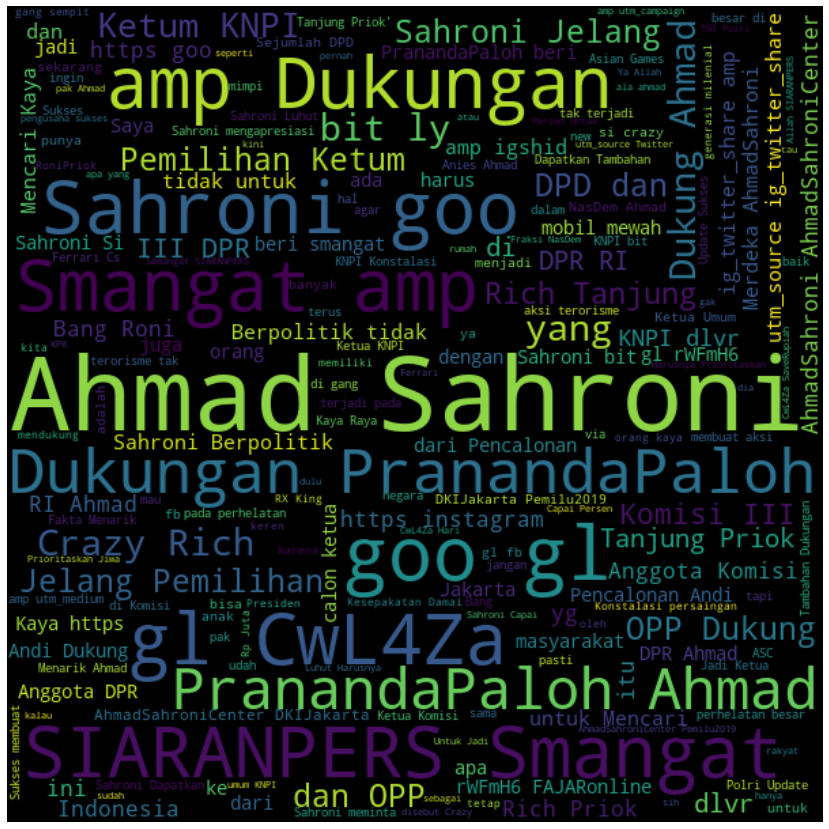

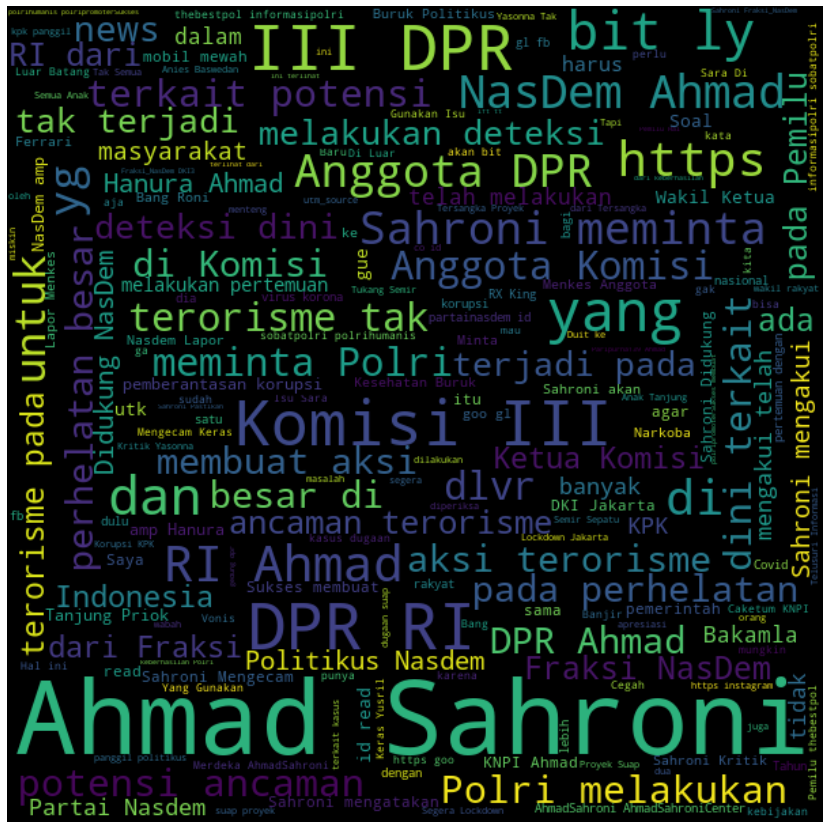

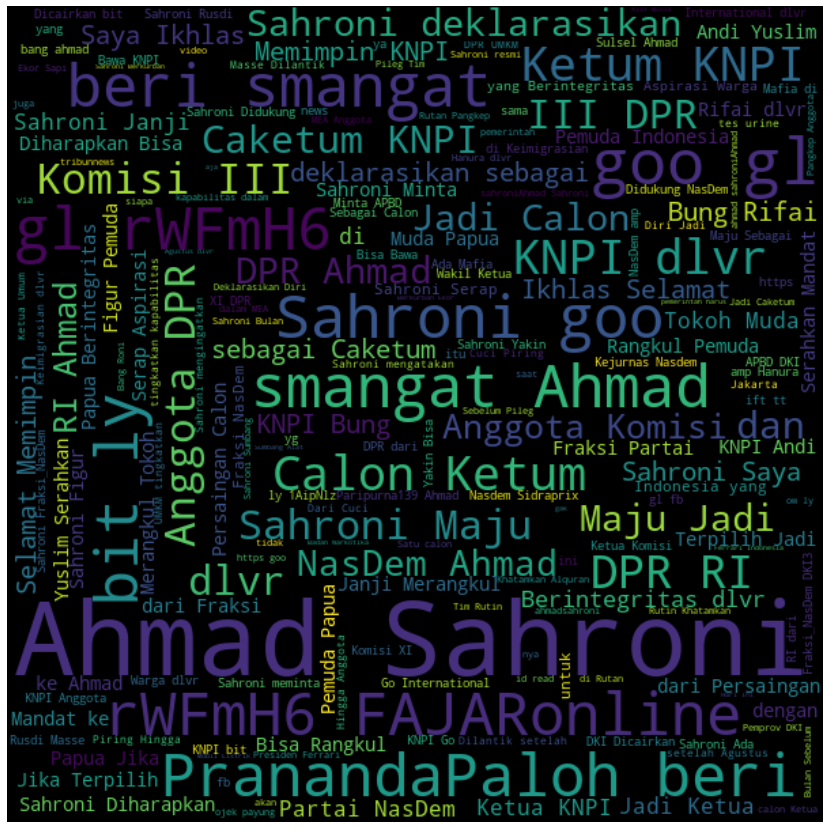

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# GENERATE POSITIVE TEXT,NEGATIVE TEXT,NEUTRAL TEXT FOR DATA-VISUALISATION
pos_text=""
neg_text=""
neut_text=""

for i in range(len(df_copy.index)):
    if(df_copy.loc[i]["sent_score_Afnn"]==1):
        pos_text+=df_copy.loc[i]["Text"]
    elif(df_copy.loc[i]["sent_score_Afnn"]==-1):
        neg_text+=df_copy.loc[i]["Text"]
    else:
        neut_text+=str(df_copy.loc[i]["Text"])

list_text = [pos_text,neg_text,neut_text]


for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(24,15))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [152]:
#TextBlob SENTIMENT LABELING
from textblob import TextBlob
count_total=0
count_pos=0
count_neg=0
count_neut=0

li_tb = []
for i in range(len(df_copy.index)):
    sent = TextBlob(str(df.loc[i]['Text_en']))
    if(sent.sentiment.polarity>0):
        count_pos=count_pos+1
        count_total=count_total+1
        li_tb.append(1)
    elif(sent.sentiment.polarity<0):
        count_neg=count_neg+1
        count_total=count_total+1
        li_tb.append(-1)
    else:
        li_tb.append(0)
        count_neut+=1

        count_total=count_total+1


#         print(df.loc[i]['full_text'])
#         print(sent.sentiment)
print("Total tweets:",len(df_copy.index))
print("Total tweets with sentiment:",count_total)
print("positive tweets:",count_pos)
print("negative tweets:",count_neg)
print("neutral tweets:",count_neut)

Total tweets: 3798
Total tweets with sentiment: 3798
positive tweets: 976
negative tweets: 322
neutral tweets: 2500


In [28]:
# Afinn sentiment LABELING
from afinn import Afinn
af = Afinn()
count_total=0
count_pos=0
count_neut=0

count_neg=0
li_af = []
for i in range(len(df_copy.index)):
    sent = str(df_copy.loc[i]['Text_en'])
    if(af.score(sent)>0):
        count_pos=count_pos+1
        count_total=count_total+1
        li_af.append(1)
    elif(af.score(sent)<0):
        count_neg=count_neg+1
        count_total=count_total+1
        li_af.append(-1)
    else:
        li_af.append(0)
        count_total=count_total+1
        count_neut+=1



#         print(df.loc[i]['full_text'])
#         print(sent.sentiment)
print("Total tweets:",len(df_copy.index))
print("Total tweets with sentiment:",count_total)
print("positive tweets:",count_pos)
print("negative tweets:",count_neg)
print("neutral tweets:",count_neut)

Total tweets: 3798
Total tweets with sentiment: 3798
positive tweets: 1384
negative tweets: 328
neutral tweets: 2086


In [46]:
df_copy.insert(6,"sent_score_Afnn",li_af,True)

In [47]:
#df_copy = df_copy.drop(df_copy.columns[[7]], axis=1)

In [48]:
df_copy

,Datetime,Text,Text_en,pos_score,neg_score,sent_score,sent_score_Afnn
0,2020-04-04 10:05:15+00:00,inspirasi sore - kisah bang ahmad sahroni http...,inspir afternoon bang stori ahmad sahroni v AS...,0.000,0.00,0,0
1,2020-04-04 08:59:07+00:00,Beberapa langkah drastis diambil oleh manajeme...,some drastic measur taken manag bodi temperatu...,1.625,0.50,1,-1
2,2020-04-03 04:27:11+00:00,Ahmad sahroni ngapain tu,ahmad sahroni tu,0.000,0.00,0,0
3,2020-04-03 02:36:51+00:00,"Sukses bisnis, mudah2an amanah di legislatif. ...",busi success mudah legisl mandat who make inte...,1.125,0.00,1,1
4,2020-04-03 00:41:27+00:00,"Politisi NasDem, Ahmad Sahroni mengatakan baha...",nasdem politician ahmad sahroni say polici tak...,0.750,0.00,1,-1
...,...,...,...,...,...,...,...
3793,2014-10-01 16:36:22+00:00,@info - Ahmad Sahroni Siap Konsolidasi Demi Ke...,ahmad sahroni readi for consolid public interest,0.000,0.25,-1,1
3794,2014-10-01 15:57:01+00:00,#TuitJabar Ahmad Sahroni Siap Konsolidasi Demi...,tuitjabar ahmad sahroni readi for consolid pub...,0.000,0.25,-1,1
3795,2014-10-01 15:56:58+00:00,Ahmad Sahroni Siap Konsolidasi Demi Kepentinga...,ahmad sahroni readi for consolid public interest,0.000,0.25,-1,1
3796,2014-10-01 15:56:52+00:00,Ahmad Sahroni Siap Konsolidasi Demi Kepentinga...,ahmad sahroni readi for consolid public interest,0.000,0.25,-1,1


In [49]:
df_copy.to_csv('useit_all_wo_duplicates_Affin.csv',index=False)